In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 60.2 MB/s 
     |████████████████████████████████| 103 kB 77.7 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 3
    n_geographic_split = 24
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by latlon_section')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('latlon_section')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


#Add new geographic coordinate classification

In [ ]:
latitude = [-90 + 180 / (CFG.n_geographic_split // 2) * i for i in range(1, CFG.n_geographic_split // 2)]
longitude = [-180 + 360 / CFG.n_geographic_split * i for i in range(CFG.n_geographic_split)]

In [ ]:
latlons = [(lat, lon) for lon in longitude for lat in latitude]
latlons.append((-90, 0))
latlons.append((90, 0))

In [ ]:
!pip install haversine
from haversine import haversine, Unit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def latlon_section(latlon):
    min_distance = float('inf')
    min_latlon = None
    for i in range(len(latlons)):
        distance = haversine(latlons[i], latlon)
        if distance < min_distance:
            min_distance = distance
            min_latlon = i
    return min_latlon
data['latlon_section'] = data[['latitude', 'longitude']].apply(latlon_section, axis = 1)
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1,1.0,140
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1,0.0,102
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0,0.0,215
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0,1.0,162
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1,1.0,140


<BarContainer object of 155 artists>

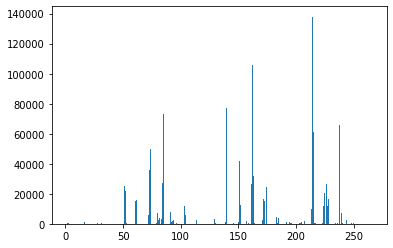

In [ ]:
plt.bar(data['latlon_section'].value_counts().index, data['latlon_section'].value_counts())

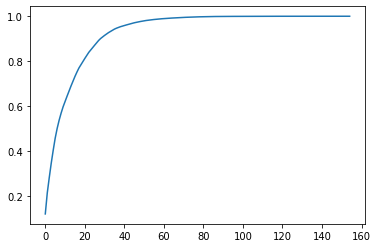

In [ ]:
counts = np.array(data['latlon_section'].value_counts())
counts_sum = counts.sum()
counts = np.sort(counts)[::-1]
plt.plot(np.arange(len(counts)), np.cumsum(counts) / counts_sum)

In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['set'] == 0, col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by latlon_section


  0%|          | 0/137 [00:00<?, ?it/s]

Start knn
Start knn grouped by latlon_section


  0%|          | 0/146 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13608979
Pos rate: 0.07402164409247747
                        id          match_id     kdist  kneighbors  \
741894    E_4d97f23f0cf767  E_eedc7310ce4026  0.000159         1.0   
6463530   E_59ff8aafa78609  E_4cd5027d62c2a2  0.000782        11.0   
4325333   E_98acfecfde921c  E_63a1cc6428076b  0.007941         7.0   
3708857   E_839aeb9b760888  E_069df801b4959f  0.002648         6.0   
13029389  E_afc1b18c61fbc2  E_6972c7571eda36       NaN         NaN   

         point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
741894    P_0c6c7742d48b27       0.000082                 2.0    0.940764   
6463530   P_8c84ed35d1287f       0.000762                18.0    0.026540   
4325333   P_2561df6b2d328f       0.006832                 8.0    0.162421   
3708857   P_ace65bc06b7f11       0.002620                 7.0    0.010786   
13029389  P_bf0a13d5a204a2       0.003998                 3.0         NaN   

          kneighbors_me

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9227816802366877


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "point_of_interest"], train_data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.60%,7.40%
development set - fold 0,91.94%,8.06%
validation set - fold 0,93.93%,6.07%
development set - fold 1,92.93%,7.07%
validation set - fold 1,91.94%,8.06%
development set - fold 2,92.93%,7.07%
validation set - fold 2,91.95%,8.05%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0454798

CV-accuracy: 0.9847686200413552


In [ ]:
del train_data
gc.collect()

291

#Check Feature Importances

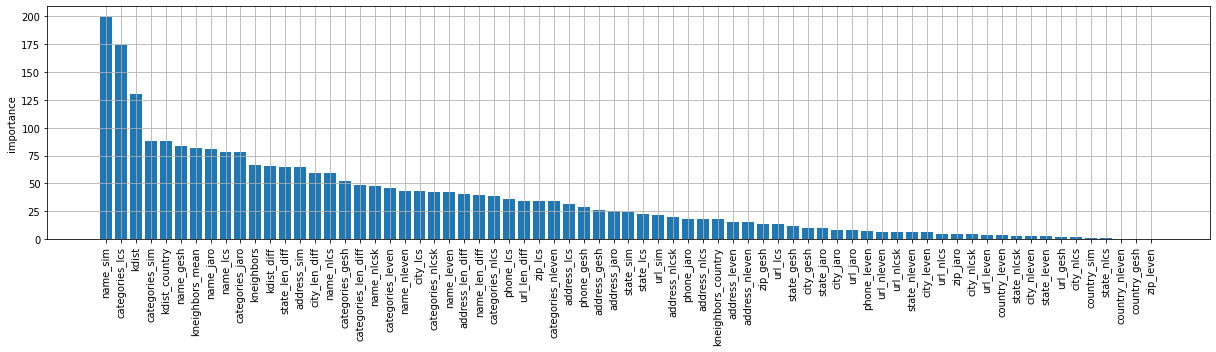

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 210 kB 75.8 MB/s 
     |████████████████████████████████| 78 kB 8.2 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 112 kB 82.7 MB/s 
     |████████████████████████████████| 146 kB 77.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=06e022a56acf5e216267dac3fa8fa1b863ac30b23f6696cf02b880f255ae7e2b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-25 15:16:50,834] A new study created in memory with name: no-name-d6c47cb7-bc6a-4752-b639-10de38f85cad
[I 2022-05-25 15:17:17,098] Trial 0 finished with value: 0.7852005404366323 and parameters: {'threshold': 0.8257744844336149}. Best is trial 0 with value: 0.7852005404366323.


CV: 0.785201


[I 2022-05-25 15:17:34,566] Trial 1 finished with value: 0.8093334982524736 and parameters: {'threshold': 0.6876660592904548}. Best is trial 1 with value: 0.8093334982524736.


CV: 0.809333


[I 2022-05-25 15:17:52,695] Trial 2 finished with value: 0.7938677188049958 and parameters: {'threshold': 0.7882790924299474}. Best is trial 1 with value: 0.8093334982524736.


CV: 0.793868


[I 2022-05-25 15:18:10,036] Trial 3 finished with value: 0.8148557419871733 and parameters: {'threshold': 0.6253359396234731}. Best is trial 3 with value: 0.8148557419871733.


CV: 0.814856


[I 2022-05-25 15:18:28,123] Trial 4 finished with value: 0.8055902532782149 and parameters: {'threshold': 0.7182157191854326}. Best is trial 3 with value: 0.8148557419871733.


CV: 0.805590


[I 2022-05-25 15:18:48,811] Trial 5 finished with value: 0.69001443680679 and parameters: {'threshold': 0.043222498340167226}. Best is trial 3 with value: 0.8148557419871733.


CV: 0.690014


[I 2022-05-25 15:19:06,706] Trial 6 finished with value: 0.795167750962407 and parameters: {'threshold': 0.7813196447782977}. Best is trial 3 with value: 0.8148557419871733.


CV: 0.795168


[I 2022-05-25 15:19:25,545] Trial 7 finished with value: 0.8170712567169583 and parameters: {'threshold': 0.35017032954603}. Best is trial 7 with value: 0.8170712567169583.


CV: 0.817071


[I 2022-05-25 15:19:43,175] Trial 8 finished with value: 0.8197160987998345 and parameters: {'threshold': 0.5160079839635556}. Best is trial 8 with value: 0.8197160987998345.


CV: 0.819716


[I 2022-05-25 15:20:00,333] Trial 9 finished with value: 0.7026168253885099 and parameters: {'threshold': 0.9691592023444638}. Best is trial 8 with value: 0.8197160987998345.


CV: 0.702617


[I 2022-05-25 15:20:19,213] Trial 10 finished with value: 0.8180171228752264 and parameters: {'threshold': 0.37118693847021106}. Best is trial 8 with value: 0.8197160987998345.


CV: 0.818017


[I 2022-05-25 15:20:37,180] Trial 11 finished with value: 0.8180006251667062 and parameters: {'threshold': 0.3706135859829076}. Best is trial 8 with value: 0.8197160987998345.


CV: 0.818001


[I 2022-05-25 15:20:55,796] Trial 12 finished with value: 0.8198934912682294 and parameters: {'threshold': 0.44587646606962666}. Best is trial 12 with value: 0.8198934912682294.


CV: 0.819893


[I 2022-05-25 15:21:14,375] Trial 13 finished with value: 0.8197010945793058 and parameters: {'threshold': 0.5152227749194996}. Best is trial 12 with value: 0.8198934912682294.


CV: 0.819701


[I 2022-05-25 15:21:34,292] Trial 14 finished with value: 0.7832548805004483 and parameters: {'threshold': 0.1584637543181942}. Best is trial 12 with value: 0.8198934912682294.


CV: 0.783255


[I 2022-05-25 15:21:51,963] Trial 15 finished with value: 0.8197188993654762 and parameters: {'threshold': 0.5108901685078665}. Best is trial 12 with value: 0.8198934912682294.


CV: 0.819719


[I 2022-05-25 15:22:11,558] Trial 16 finished with value: 0.797442819482692 and parameters: {'threshold': 0.20311761508073847}. Best is trial 12 with value: 0.8198934912682294.


CV: 0.797443


[I 2022-05-25 15:22:29,151] Trial 17 finished with value: 0.8165165020098273 and parameters: {'threshold': 0.5993501000378074}. Best is trial 12 with value: 0.8198934912682294.


CV: 0.816517


[I 2022-05-25 15:22:48,398] Trial 18 finished with value: 0.80996431145347 and parameters: {'threshold': 0.2717403397727217}. Best is trial 12 with value: 0.8198934912682294.


CV: 0.809964


[I 2022-05-25 15:23:07,308] Trial 19 finished with value: 0.8197769234575316 and parameters: {'threshold': 0.428553838325226}. Best is trial 12 with value: 0.8198934912682294.


CV: 0.819777


[I 2022-05-25 15:23:25,137] Trial 20 finished with value: 0.8196405253930806 and parameters: {'threshold': 0.42095974850255286}. Best is trial 12 with value: 0.8198934912682294.


CV: 0.819641


[I 2022-05-25 15:23:43,767] Trial 21 finished with value: 0.8201518929126382 and parameters: {'threshold': 0.478705729994069}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.820152


[I 2022-05-25 15:24:02,330] Trial 22 finished with value: 0.8200099705660246 and parameters: {'threshold': 0.4545241648538626}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.820010


[I 2022-05-25 15:24:21,547] Trial 23 finished with value: 0.8119531386262111 and parameters: {'threshold': 0.2887492282687581}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.811953


[I 2022-05-25 15:24:39,142] Trial 24 finished with value: 0.8172261798429835 and parameters: {'threshold': 0.5854955279798626}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.817226


[I 2022-05-25 15:24:57,837] Trial 25 finished with value: 0.8197929727017162 and parameters: {'threshold': 0.43402044783909877}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.819793


[I 2022-05-25 15:25:16,960] Trial 26 finished with value: 0.7765603409044565 and parameters: {'threshold': 0.1419147724207686}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.776560


[I 2022-05-25 15:25:36,046] Trial 27 finished with value: 0.8117317533276408 and parameters: {'threshold': 0.28655153155081775}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.811732


[I 2022-05-25 15:25:54,815] Trial 28 finished with value: 0.820012326438619 and parameters: {'threshold': 0.45437195270310377}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.820012


[I 2022-05-25 15:26:12,228] Trial 29 finished with value: 0.8183711841387571 and parameters: {'threshold': 0.55820218333409}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.818371


[I 2022-05-25 15:26:29,876] Trial 30 finished with value: 0.7510511369506386 and parameters: {'threshold': 0.9128154240363455}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.751051


[I 2022-05-25 15:26:48,628] Trial 31 finished with value: 0.8200457774709499 and parameters: {'threshold': 0.45814961517893876}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.820046


[I 2022-05-25 15:27:07,467] Trial 32 finished with value: 0.8201276637493028 and parameters: {'threshold': 0.48124369346311935}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.820128


[I 2022-05-25 15:27:24,824] Trial 33 finished with value: 0.808835312083706 and parameters: {'threshold': 0.6918976119439535}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.808835


[I 2022-05-25 15:27:43,188] Trial 34 finished with value: 0.810726589001795 and parameters: {'threshold': 0.6741480737576693}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.810727


[I 2022-05-25 15:28:00,789] Trial 35 finished with value: 0.8187244820415126 and parameters: {'threshold': 0.5505121627456675}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.818724


[I 2022-05-25 15:28:18,969] Trial 36 finished with value: 0.8155053594657855 and parameters: {'threshold': 0.6150308051748659}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.815505


[I 2022-05-25 15:28:37,896] Trial 37 finished with value: 0.8166684823771517 and parameters: {'threshold': 0.34447111223153676}. Best is trial 21 with value: 0.8201518929126382.


CV: 0.816668


[I 2022-05-25 15:28:55,726] Trial 38 finished with value: 0.8201567195012417 and parameters: {'threshold': 0.476692507339023}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.820157


[I 2022-05-25 15:29:14,028] Trial 39 finished with value: 0.8116846271136136 and parameters: {'threshold': 0.6637375886243007}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.811685


[I 2022-05-25 15:29:32,869] Trial 40 finished with value: 0.8001572162536347 and parameters: {'threshold': 0.7541148684195922}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.800157


[I 2022-05-25 15:29:51,659] Trial 41 finished with value: 0.8200673781246907 and parameters: {'threshold': 0.483269350514454}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.820067


[I 2022-05-25 15:30:09,402] Trial 42 finished with value: 0.8201461394077181 and parameters: {'threshold': 0.47923227878624497}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.820146


[I 2022-05-25 15:30:27,959] Trial 43 finished with value: 0.819856164670183 and parameters: {'threshold': 0.4955585808073753}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.819856


[I 2022-05-25 15:30:45,843] Trial 44 finished with value: 0.81822837166693 and parameters: {'threshold': 0.37576024611575215}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.818228


[I 2022-05-25 15:31:04,265] Trial 45 finished with value: 0.8138806320867639 and parameters: {'threshold': 0.6380206546484197}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.813881


[I 2022-05-25 15:31:23,297] Trial 46 finished with value: 0.8188625442540248 and parameters: {'threshold': 0.39517846820169744}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.818863


[I 2022-05-25 15:31:41,310] Trial 47 finished with value: 0.8153387569101773 and parameters: {'threshold': 0.3260893602827548}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.815339


[I 2022-05-25 15:31:59,700] Trial 48 finished with value: 0.8187469032546708 and parameters: {'threshold': 0.550079568593414}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.818747


[I 2022-05-25 15:32:18,272] Trial 49 finished with value: 0.8197853052065104 and parameters: {'threshold': 0.5083566495590525}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.819785


[I 2022-05-25 15:32:36,913] Trial 50 finished with value: 0.8201371589706877 and parameters: {'threshold': 0.479778370723738}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.820137


[I 2022-05-25 15:32:54,799] Trial 51 finished with value: 0.8201367988106515 and parameters: {'threshold': 0.4810194545136346}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.820137


[I 2022-05-25 15:33:13,380] Trial 52 finished with value: 0.8191296163885431 and parameters: {'threshold': 0.5399959231060281}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.819130


[I 2022-05-25 15:33:32,292] Trial 53 finished with value: 0.819111704993271 and parameters: {'threshold': 0.40307877423042576}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.819112


[I 2022-05-25 15:33:49,845] Trial 54 finished with value: 0.8172696063266687 and parameters: {'threshold': 0.5847973358634858}. Best is trial 38 with value: 0.8201567195012417.


CV: 0.817270


[I 2022-05-25 15:34:08,368] Trial 55 finished with value: 0.8201581018494741 and parameters: {'threshold': 0.47732882571789964}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820158


[I 2022-05-25 15:34:27,285] Trial 56 finished with value: 0.8157304298720148 and parameters: {'threshold': 0.3301982998436167}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.815730


[I 2022-05-25 15:34:45,882] Trial 57 finished with value: 0.8195328461912993 and parameters: {'threshold': 0.5235649367282407}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819533


[I 2022-05-25 15:35:04,018] Trial 58 finished with value: 0.8054862263262016 and parameters: {'threshold': 0.24086219157421385}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.805486


[I 2022-05-25 15:35:25,691] Trial 59 finished with value: 0.6486987821912957 and parameters: {'threshold': 0.028614809162482713}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.648699


[I 2022-05-25 15:35:44,398] Trial 60 finished with value: 0.8187280390031079 and parameters: {'threshold': 0.3896027055313059}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.818728


[I 2022-05-25 15:36:02,121] Trial 61 finished with value: 0.8201526993032757 and parameters: {'threshold': 0.4775260561415042}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820153


[I 2022-05-25 15:36:20,932] Trial 62 finished with value: 0.8200995450831524 and parameters: {'threshold': 0.4695618854215933}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820100


[I 2022-05-25 15:36:39,673] Trial 63 finished with value: 0.8196384506603704 and parameters: {'threshold': 0.4204573503282658}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819638


[I 2022-05-25 15:36:58,222] Trial 64 finished with value: 0.8175538407099219 and parameters: {'threshold': 0.57855160381161}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.817554


[I 2022-05-25 15:37:15,956] Trial 65 finished with value: 0.8197948504517006 and parameters: {'threshold': 0.49883829728813456}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819795


[I 2022-05-25 15:37:34,643] Trial 66 finished with value: 0.8197957730743851 and parameters: {'threshold': 0.43298528012790055}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819796


[I 2022-05-25 15:37:52,847] Trial 67 finished with value: 0.8140117844291206 and parameters: {'threshold': 0.6365138837784927}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.814012


[I 2022-05-25 15:38:11,302] Trial 68 finished with value: 0.8193331828038285 and parameters: {'threshold': 0.5319053858596633}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819333


[I 2022-05-25 15:38:29,971] Trial 69 finished with value: 0.8200736125496455 and parameters: {'threshold': 0.4639347905023227}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820074


[I 2022-05-25 15:38:48,005] Trial 70 finished with value: 0.8179731351609608 and parameters: {'threshold': 0.36880449103313634}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.817973


[I 2022-05-25 15:39:06,630] Trial 71 finished with value: 0.8200715189380654 and parameters: {'threshold': 0.4832154394149675}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820072


[I 2022-05-25 15:39:24,043] Trial 72 finished with value: 0.8177650504693924 and parameters: {'threshold': 0.574105685025655}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.817765


[I 2022-05-25 15:39:42,643] Trial 73 finished with value: 0.8195749405525116 and parameters: {'threshold': 0.41831572359191715}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819575


[I 2022-05-25 15:40:01,413] Trial 74 finished with value: 0.8200058052800411 and parameters: {'threshold': 0.4511353962723364}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820006


[I 2022-05-25 15:40:18,992] Trial 75 finished with value: 0.8197012159432541 and parameters: {'threshold': 0.5142292169922271}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819701


[I 2022-05-25 15:40:37,495] Trial 76 finished with value: 0.8200283784421964 and parameters: {'threshold': 0.4857634597136139}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820028


[I 2022-05-25 15:40:55,792] Trial 77 finished with value: 0.8159824413523862 and parameters: {'threshold': 0.6080844265470092}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.815982


[I 2022-05-25 15:41:14,198] Trial 78 finished with value: 0.8180970097638876 and parameters: {'threshold': 0.5628924705637144}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.818097


[I 2022-05-25 15:41:32,701] Trial 79 finished with value: 0.8198376652145782 and parameters: {'threshold': 0.44070195393448974}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819838


[I 2022-05-25 15:41:51,093] Trial 80 finished with value: 0.8195246530444334 and parameters: {'threshold': 0.5233017041566833}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819525


[I 2022-05-25 15:42:08,707] Trial 81 finished with value: 0.8201475569367687 and parameters: {'threshold': 0.4720960108507528}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820148


[I 2022-05-25 15:42:27,174] Trial 82 finished with value: 0.8201485590253516 and parameters: {'threshold': 0.47557442403106265}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820149


[I 2022-05-25 15:42:46,119] Trial 83 finished with value: 0.8192384371911389 and parameters: {'threshold': 0.40617639082110446}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819238


[I 2022-05-25 15:43:04,030] Trial 84 finished with value: 0.8169314607661723 and parameters: {'threshold': 0.3487557516669168}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.816931


[I 2022-05-25 15:43:22,567] Trial 85 finished with value: 0.8201022989860486 and parameters: {'threshold': 0.4685851428937131}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820102


[I 2022-05-25 15:43:40,433] Trial 86 finished with value: 0.8182279280695866 and parameters: {'threshold': 0.3759934235299245}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.818228


[I 2022-05-25 15:43:58,984] Trial 87 finished with value: 0.8198074108023068 and parameters: {'threshold': 0.44320784439395655}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819807


[I 2022-05-25 15:44:17,591] Trial 88 finished with value: 0.8190994266262441 and parameters: {'threshold': 0.540612005729818}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819099


[I 2022-05-25 15:44:36,249] Trial 89 finished with value: 0.8197869091857702 and parameters: {'threshold': 0.5041881231997297}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819787


[I 2022-05-25 15:44:53,822] Trial 90 finished with value: 0.8166217063334227 and parameters: {'threshold': 0.5972739737715236}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.816622


[I 2022-05-25 15:45:12,426] Trial 91 finished with value: 0.8201497854458834 and parameters: {'threshold': 0.4787360666937823}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820150


[I 2022-05-25 15:45:31,020] Trial 92 finished with value: 0.8199082542352911 and parameters: {'threshold': 0.492958832235422}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819908


[I 2022-05-25 15:45:49,490] Trial 93 finished with value: 0.8200823470332793 and parameters: {'threshold': 0.4666211212091853}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.820082


[I 2022-05-25 15:46:07,811] Trial 94 finished with value: 0.8185911383243684 and parameters: {'threshold': 0.5534101405085812}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.818591


[I 2022-05-25 15:46:26,753] Trial 95 finished with value: 0.8144741210361327 and parameters: {'threshold': 0.31619664840133854}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.814474


[I 2022-05-25 15:46:45,471] Trial 96 finished with value: 0.8195218847324887 and parameters: {'threshold': 0.4169044656796842}. Best is trial 55 with value: 0.8201581018494741.


CV: 0.819522


In [ ]:
threshold = study.best_params['threshold']
threshold

In [ ]:
study.best_value

In [37]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.820158


# 間違っているものの中身を見る

In [38]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [39]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,152107.000000,152107.000000,148487.000000,148487.000000,143297.000000,156328.000000,156328.0,156328.000000,156328.000000,156328.000000,...,156328.000000,156324.000000,156324.000000,156324.000000,156324.000000,156328.000000,156324.000000,156324.000000,156324.000000,156328.000000
mean,0.006150,6.214494,0.003823,6.236411,0.422958,6.494777,1.0,0.264190,0.416547,16.260747,...,0.998836,0.998925,0.002194,0.998917,1.997851,0.000026,0.001097,0.998925,0.998925,0.179568
std,0.046246,5.198931,0.031652,5.206191,2.315207,5.265822,0.0,0.309507,0.251917,9.481978,...,0.034101,0.032273,0.065577,0.032612,0.064546,0.005058,0.032789,0.032273,0.032273,0.144361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000033
25%,0.000436,2.000000,0.000331,2.000000,0.006058,2.000000,1.0,0.000000,0.210526,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.046670
50%,0.001097,4.000000,0.000854,4.000000,0.057167,5.000000,1.0,0.000000,0.400000,15.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.149706
75%,0.003080,10.000000,0.002427,10.000000,0.323337,10.000000,1.0,0.516540,0.600000,22.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.297292
max,4.310371,19.000000,2.388985,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.477328


In [40]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
1973261,E_77045c237d1d5f,E_41aa2c325d0cb8,0.001422,3.0,P_d1f8b793f4d744,0.000997,3.0,4.260964e-01,3.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.005491
8284033,E_8c43cb4b64d69c,E_244f67567762e0,0.005293,14.0,P_b5f65860363d2b,0.004672,13.0,1.328243e-01,13.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.194446
13430263,E_92bb3f9afa7537,E_1d87161ebee9a2,NaN,NaN,P_5ba0a5f6589815,0.002075,15.0,NaN,15.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.130025
3223066,E_a8d309f99139b5,E_511759591f0c3f,0.003580,5.0,P_33e827907ec7d7,0.003559,5.0,5.981287e-03,5.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.197699
2041743,E_95b52ba181c63e,E_8850a570a55e9f,0.000361,3.0,P_e8a16965b015fd,0.000251,4.0,4.412016e-01,3.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.004662
923542,E_9eea38e3e86d02,E_f39a0412ab0b9b,0.005229,1.0,P_1c170ade4735a7,0.005149,1.0,1.536976e-02,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.050962
2124393,E_bace35d9cc43c4,E_885cde8ae8ff0e,0.003227,3.0,P_2ea9a1b708d0b4,0.003227,3.0,1.808494e-07,3.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.004477
3336121,E_dbb89da34ebc0e,E_997d6ae99e8ff1,0.000512,5.0,P_2c4e56919ce435,0.000456,5.0,1.232203e-01,5.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.059005
4954121,E_b30bf9e144ba0a,E_28c5ade626b7cc,0.001820,8.0,P_022ebb5a83c60d,0.001809,8.0,5.796304e-03,8.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.144694
5904296,E_5e705454087339,E_376430030f6b1b,0.000834,10.0,P_81172a3acce011,0.000826,10.0,9.571279e-03,10.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.270972


In [41]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
332288,E_4ab12bf03e3413,Школа № 89,60.029183,30.419993,"ул. Черкасова, 8, корп. 2",Санкт-Петербург,Санкт-Петербург,195265,RU,NaN,NaN,Schools,P_78d12fbd779203,4,1.0,163
847708,E_be5f06c938d1e4,Толкан на 2,60.028602,30.420307,Черкасова 8 к. 2,Санкт Петербург,NaN,NaN,RU,NaN,NaN,NaN,P_78d12fbd779203,4,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
211297,E_2f6edf3c016f7b,田中美久レーン,34.636604,135.419495,NaN,NaN,NaN,NaN,JP,NaN,NaN,Music Festivals,P_6cd4394f8bcc37,4,1.0,238
387122,E_56f8aab567e3a8,今村麻莉愛レーン,34.637865,135.419212,NaN,NaN,NaN,NaN,JP,NaN,NaN,Elementary Schools,P_6cd4394f8bcc37,4,1.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
583516,E_832ba423fbc538,De Spar,46.499824,11.356784,NaN,Bolzano,Trentino-Alto Adige/Südtirol,NaN,IT,NaN,NaN,Shops & Services,P_b0d6eda1871a89,1,1.0,151
758321,E_aa5a98e78ee84d,Despar,46.500095,11.356330,Bindergasse 29,Bolzano / Bozen,BZ,39100,IT,http://www.despar.it,0471970746,Supermarkets,P_b0d6eda1871a89,1,1.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
285198,E_4007709d2fe2ed,AZ-sint Jan,51.219744,3.192663,Ruddershove 10,Brugge,NaN,8000,BE,NaN,NaN,"Hospitals, Medical Labs, Buildings",P_77dfd9dc131071,4,1.0,140
578675,E_8215853d25ec64,AZ Sint-Jan kamer 7632,51.220565,3.193445,NaN,NaN,NaN,NaN,BE,NaN,NaN,Medical Centers,P_77dfd9dc131071,4,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
11827,E_02b0d78631b01f,McDonald's,29.329396,47.991834,AlRawda,Kuwait,Kuwait city,NaN,KW,NaN,NaN,Fast Food Restaurants,P_2196c593c25295,4,1.0,172
501744,E_70d0b80fc4b205,MaCheTe,29.326768,47.999934,NaN,NaN,NaN,NaN,KW,NaN,NaN,Strip Clubs,P_2196c593c25295,4,1.0,172


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
100344,E_167e5c5dde24d5,Bellas Estética Unha e Depilção,-3.730440,-38.592728,Rua Neide Maria Lima,Fortaleza,Ceará,60351-092,BR,NaN,+558587406488,Nail Salons,P_f73d65b0139e78,2,1.0,104
805274,E_b4d4702b1d49a9,Bellas Unhas-(85)987406488,-3.730304,-38.592740,"Rua Neide Maria Lima Frota Cavalcante, 38",Fortaleza,Ceará,60351-092,BR,NaN,NaN,Nail Salons,P_f73d65b0139e78,2,1.0,104


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
404326,E_5adb2af3f69c58,Autobusa pietura t/c Bulduri,56.983488,23.856415,NaN,NaN,NaN,NaN,LV,NaN,NaN,Bus Stops,P_652d1ea20e0041,2,1.0,163
624882,E_8c7fad093955df,"""Autobusu pietura \"" TC Bulduri\""""",56.983322,23.855513,Meža prospekts,Jūrmala,NaN,NaN,LV,NaN,NaN,Bus Stops,P_652d1ea20e0041,2,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
708038,E_9f07eed83b9e5a,fungo tunalı,39.903473,32.860862,NaN,NaN,NaN,NaN,TR,NaN,NaN,Italian Restaurants,P_19625d2be4c545,2,1.0,162
864402,E_c22a270d0b5628,Fungo Pizza & Kitchen,39.903671,32.860468,NaN,NaN,Ankara,06680,TR,NaN,NaN,"Pizza Places, Fast Food Restaurants, Italian R...",P_19625d2be4c545,2,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
245702,E_37212d20678719,KFC sarinah,-7.981030,112.630384,NaN,Malang,Malang,NaN,ID,NaN,NaN,Fast Food Restaurants,P_3b315bf6298601,4,1.0,224
907111,E_cbc5bd960a80b1,KFC Coffee Sarinah,-7.981069,112.630561,NaN,NaN,NaN,NaN,ID,NaN,NaN,Coffee Shops,P_3b315bf6298601,4,1.0,224


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
478502,E_6b8c1b36eebf28,Sultan Iskandar CIQ Complex (Johor Bahru Check...,1.464377,103.765783,Jln Sultan Ibrahim,Johor Bahru,Johor,80300,MY,http://www.customs.gov.my,NaN,Border Crossings,P_a7829bfa2c8bc6,4,1.0,214
829398,E_ba417fe840f5e8,"AutoGate (SG-JHB) Entry, BSI",1.464679,103.767066,Bangunan Sultan Iskandar,Johor Bahru,Johor,80300,MY,NaN,NaN,Border Crossings,P_a7829bfa2c8bc6,4,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
492309,E_6eadf354b06618,Aroon(rai) อรุณ(ไร),18.786321,98.993494,Kochasarn Road,เชียงใหม่,NaN,NaN,TH,NaN,+6653276947,Thai Restaurants,P_4e00dba70a4080,2,1.0,215
811603,E_b644644dff4d36,Oringinal Aroon Rai's Curry,18.786363,98.993561,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_4e00dba70a4080,2,1.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
329041,E_49f63c06fe88ba,Myeong Dong,37.560159,126.985660,NaN,NaN,NaN,NaN,KR,NaN,NaN,Markets,P_49ef7bc4158475,4,1.0,228
932257,E_d1695a60f76688,명동역 4번 출구,37.560017,126.984901,NaN,NaN,NaN,NaN,KR,NaN,NaN,Metro Stations,P_49ef7bc4158475,4,1.0,228


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
478988,E_6ba7336c7f3999,Tai Po Industrial Estate,22.456361,114.182278,3 Dai Shing St,Tai Po,NaN,NaN,HK,NaN,NaN,Industrial Estates,P_717c6a814b411f,1,1.0,227
1060126,E_ee3da982cac3b6,大埔工業,22.451002,114.192909,NaN,NaN,NaN,NaN,HK,NaN,NaN,NaN,P_717c6a814b411f,1,1.0,227


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
555408,E_7cd200f3ddeb2f,Amasya Erkek Öğrenci Yurdu B Blok,40.649365,35.795807,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_37472858a716a3,4,1.0,162
800703,E_b3d1cae8b7bb6a,Kyk B Blok318. Oda,40.648477,35.795888,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Residence Halls,P_37472858a716a3,4,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
849562,E_becab81c235779,GMIM NAFIRI klm 9,1.453176,124.812234,Malalayang,Kota Manado,Sulawesi Utara,NaN,ID,NaN,NaN,NaN,P_b659d31d18346f,3,1.0,225
1122235,E_fc4615f1c45e21,Kolom 1 Nafiri,1.454460,124.815674,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_b659d31d18346f,3,1.0,225


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
37656,E_087243b310fc63,Chimy's,32.749159,-97.355636,1053 Foch St,Fort Worth,TX,76107,US,http://chimys.com/,8173488888,"Mexican Restaurants, Bars, Beer Gardens",P_7df390a1ac60a2,2,1.0,73
618859,E_8b25315b1521a6,chimi,32.750103,-97.356308,NaN,Fort Worth,TX,NaN,US,NaN,NaN,Mexican Restaurants,P_7df390a1ac60a2,2,1.0,73


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
635011,E_8ec5b555e3ef98,"Инфа, кабинет 29 💻",55.805143,37.531562,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_0a5c9c3a36434c,4,1.0,174
672067,E_96f853dfdafc5f,Арифметический Бар🍹🍸,55.804880,37.531531,"Улица Усиевича, 6",NaN,NaN,NaN,RU,NaN,NaN,Beach Bars,P_0a5c9c3a36434c,4,1.0,174


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
123976,E_1bcb180a8ac314,Istanbul Adalet Sarayı Çocuk Savcılığı,41.069700,28.980110,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_f2df149bcb3843,4,1.0,162
743012,E_a6ed695a7ba70c,İstanbul 6. Çocuk Mahkemesi,41.069495,28.980367,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_f2df149bcb3843,4,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
461278,E_67a12e15479b10,Mont Bleu Hotel & Spa,38.963914,-119.939117,55 Highway 50,Stateline,NV,89449,US,http://www.montbleuresort.com,8888297630,"Hotels, Spas, Resorts",P_6d59dc89c7095a,1,1.0,52
1047488,E_eb5e6ae0ec00da,MontBleu Resort Casino & Spa,38.961613,-119.939731,"55 Highway 50, POBOX5800",Stateline,NV,89449,US,https://www.montbleuresort.com,+17755883515,"Casinos, Hotels, Theaters",P_6d59dc89c7095a,1,1.0,52


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
18340,E_0420e96ac5f2c7,Ceyhan Devlet Hastanesi Göğüs Cerrahi Polikliniği,37.026974,35.819770,ulus mahallesi ceyhan devlet hastanesi,Ceyhan,Ceyhan,01960,TR,NaN,NaN,Hospitals,P_89d44aa95f0838,3,1.0,161
741676,E_a6a06c49e9e815,Ceyhan Devlet Hastanesi Kulak Burun Boğaz Poli...,37.026497,35.819525,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_89d44aa95f0838,3,1.0,161


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
258931,E_3a2254a4b1dfd1,Школа № 1234,55.753428,37.590092,"ул. Большая Молчановка, 26-28",Москва,Москва,121069,RU,http://sch1234c.mskobr.ru,4956916441,Schools,P_eebf6645b1dd8b,4,1.0,174
544880,E_7a73b13a929cd6,Коридор на 2 Этаже 1234,55.753331,37.590195,NaN,город Москва,Москва,NaN,RU,NaN,NaN,College Academic Buildings,P_eebf6645b1dd8b,4,1.0,174


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
201146,E_2d22626f27d958,"Heritage Park, Mortuary&Crematory lobby",14.516763,121.045288,Taguig city,NaN,NaN,1633,PH,NaN,NaN,Campaign Offices,P_c0913c8cf22c14,1,1.0,226
245618,E_371bf1b39282e1,Heritage Memorial Park Mortuary & Crematorium,14.517028,121.045181,Carlos P. Garcia Avenue (C-5),Taguig,NaN,NaN,PH,NaN,NaN,Funeral Homes,P_c0913c8cf22c14,1,1.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
687320,E_9a5e3879a99d53,ひろ屋 QVCマリン店,35.644859,140.031651,美浜区美浜1,千葉市,千葉県,NaN,JP,NaN,NaN,Snack Places,P_f5d6400da5eafa,4,1.0,238
935010,E_d207a86940a358,Festa,35.645772,140.031537,美浜1,NaN,NaN,NaN,JP,NaN,NaN,Karaoke Bars,P_f5d6400da5eafa,4,1.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
188805,E_2a5ab5b05f9d95,千住宿 喜田家,35.710180,139.810142,押上1-1-2,墨田区,東京都,131-0045,JP,http://kitaya.info,358097185,Wagashi Places,P_e35eaf1286e3a8,1,1.0,238
975411,E_db1c4962b7e383,喜田屋 ソラマチ店,35.710022,139.810959,NaN,NaN,NaN,NaN,JP,NaN,NaN,Candy Stores,P_e35eaf1286e3a8,1,1.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
564480,E_7edb620abb8d7a,The Rose Gallery,28.421179,-81.580724,NaN,Bay Lake,FL,NaN,US,NaN,NaN,French Restaurants,P_0af2c4b21ad7a9,4,1.0,84
575687,E_816724ee3f2550,Be Our Guest Restaurant,28.421213,-81.580729,"Fantasyland, Magic Kingdom",Lake Buena Vista,FL,32836,US,https://disneyworld.disney.go.com/dining/magic...,4079393463,French Restaurants,P_0af2c4b21ad7a9,4,1.0,84


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
124597,E_1beb82b3d25a76,резиденция космогооош,52.971606,36.065346,Пролетарская Гора 7,Орел,NaN,NaN,RU,NaN,NaN,NaN,P_866bdf11821c70,3,1.0,163
673896,E_976217c47b407b,хата арвата,52.972023,36.061895,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_866bdf11821c70,3,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
597480,E_864835312a4733,Çayeli Dergah Pastaneleri,41.087604,40.724231,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bakeries,P_74262b2b72c926,1,1.0,173
707666,E_9ef2fc74cb94ef,Dergah Pastanesi,41.087582,40.724209,Yenipazar Mah.,Çayeli,Rize,53200,TR,NaN,NaN,Pastry Shops,P_74262b2b72c926,1,1.0,173


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
12228,E_02c5fec9734999,Кабинет Гены 14 🙈🔫,59.454590,32.011562,NaN,NaN,NaN,NaN,RU,NaN,NaN,High Schools,P_6edadd37c47c43,4,1.0,163
989991,E_de66d535091a10,18 кабинет изо,59.455433,32.011573,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_6edadd37c47c43,4,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
393558,E_586d47f1e62797,"Mcd drive thru, Taman Melati•̸Ϟ•̸-̶̶-̶~♔",3.147410,101.754150,NaN,NaN,NaN,NaN,MY,NaN,NaN,Fast Food Restaurants,P_5d1cd8f7ea26b0,4,1.0,214
1105292,E_f870060f07aacc,Mekdunel,3.145872,101.754685,Petronas Taman Dagang,NaN,NaN,NaN,MY,NaN,NaN,Fast Food Restaurants,P_5d1cd8f7ea26b0,4,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
371678,E_5383de0806720d,"depan UKS , SMAN 2",-7.255929,112.747599,Wijayakusuma no. 48,Surabaya,Indonesia,NaN,ID,NaN,NaN,NaN,P_d1c36eceb6334b,4,1.0,225
1059943,E_ee33af70dc6c59,Bangsal sman 2 surabaya,-7.256477,112.749835,Jl. Wijaya Kusuma 48,Surabaya,Jawa Timur,NaN,ID,NaN,NaN,NaN,P_d1c36eceb6334b,4,1.0,225


labelが0なのに1と予測しているもの

In [42]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,59879.000000,59879.000000,57115.000000,57115.000000,55469.000000,60922.000000,60922.0,60922.000000,60922.000000,60922.000000,...,60922.000000,60918.000000,60918.000000,60918.000000,60918.000000,60922.0,60918.000000,60918.000000,60918.000000,60922.000000
mean,0.014585,4.530520,0.003431,4.327094,0.398667,4.759184,0.0,0.599097,0.620316,11.632875,...,0.997275,0.997546,0.005138,0.997461,1.995092,0.0,0.002569,0.997546,0.997546,0.678501
std,0.175340,4.949155,0.019816,4.763800,1.656198,5.064502,0.0,0.352794,0.248504,9.111489,...,0.052129,0.048431,0.100346,0.049924,0.096861,0.0,0.050173,0.048431,0.048431,0.137369
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.477335
25%,0.000295,1.000000,0.000220,1.000000,0.007394,1.000000,0.0,0.368647,0.457143,5.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.558800
50%,0.000872,2.000000,0.000637,2.000000,0.066128,2.000000,0.0,0.685910,0.638298,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.659713
75%,0.003040,6.000000,0.002095,6.000000,0.315429,7.000000,0.0,0.917276,0.810811,17.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.785998
max,17.187599,19.000000,1.385816,19.000000,94.717490,19.000000,0.0,1.000000,1.000000,56.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999491


In [43]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
944346,E_a852f22269d9b3,E_0b27f60035b75e,0.000000,1.0,P_342466a6430699,0.000000,0.0,NaN,0.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.646633
807368,E_6ad342f4ac1048,E_72c11546267629,0.000594,1.0,P_fa8133307733eb,0.000572,1.0,3.806411e-02,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.665354
597128,E_0c6dfa89b4df64,E_83c75023c306ad,0.000543,1.0,P_9fcf8b9255dd33,0.000543,1.0,1.170145e-04,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.914216
1406085,E_780d75afbab9e9,E_596a73f208811b,0.000150,2.0,P_3c2d9adea5e2cb,0.000143,2.0,4.990301e-02,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.506046
2648358,E_a66f6d9d73591c,E_9a11afbe5c280f,0.001226,4.0,P_e00d405d51137f,0.000942,4.0,3.009443e-01,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.786257
937509,E_a53e8f4f5b8aad,E_d262292919986d,0.000043,1.0,P_7b5ab91992a613,0.000035,1.0,2.156515e-01,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.716006
865053,E_84bd10ed596765,E_e7e33ba91ebf4b,0.000505,1.0,P_3c9a1ee25af109,0.000505,2.0,2.827173e-04,1.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.849333
1168382,E_0d3fcdae203923,E_2f46d5be5e9b84,0.000286,2.0,P_1339f0202967ec,0.000286,2.0,5.551725e-06,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.514614
6255930,E_fc956e1d4b1a84,E_d70227e3f37e80,0.002894,10.0,P_b6c75b015c5bc4,0.002894,10.0,1.264671e-09,10.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.536127
684320,E_337d654c36ce02,E_aaeca2cb1532c2,0.000391,1.0,P_f67fd97a371d1b,0.000352,1.0,1.115954e-01,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.652746


In [44]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
71782,E_100d8bad5267a9,Singtel Shop,1.324738,103.932440,"#03-22, Bedok Point",Singapore,NaN,467351,SG,NaN,NaN,"Mobile Phone Shops, Electronics Stores",P_e0e191fed33b5c,0,1.0,214
1016212,E_e44ccb87d2cda4,Singtel,1.325041,103.932642,NaN,NaN,NaN,NaN,SG,NaN,NaN,Electronics Stores,P_91319cfc7f73ec,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
23119,E_05321190995f8d,Hotel De La Clape,43.159300,3.166116,NaN,Narbonne,Occitanie,11100,FR,NaN,NaN,Hotels,P_1ce7184dce1a32,0,1.0,140
219072,E_31311565ea17fa,Restaurant de la Clape,43.159328,3.166133,4 Rue des Fleurs,Narbonne,Occitanie,11100,FR,http://www.restaurant-delaclape-narbonne.fr/o/...,0468498015,"Restaurants, Hotels",P_b0c514bb0833d3,0,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
150919,E_21d52a1b6546be,Balikpapan baru,-1.244557,116.884849,NaN,Balikpapan,East Borneo,NaN,ID,NaN,NaN,NaN,P_de0049eaf4caf5,0,1.0,225
474209,E_6a92d6e6c8aa5a,Ring Road Balikpapan,-1.243576,116.885291,Jl. MT. Haryono,Balikpapan,East Kalimantan,NaN,ID,NaN,NaN,NaN,P_dafe92d45d50f1,0,1.0,225


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
261343,E_3aad6cb0d93c93,CAP — Ministério da Saúde,-15.801676,-47.869057,NaN,NaN,NaN,NaN,BR,NaN,NaN,Government Buildings,P_ed2b86c6e77aa0,0,1.0,103
673082,E_9733349444bd59,Ministério da Previdência Social,-15.801392,-47.869515,Esplanada dos Ministérios - Bloco F,Brasília,DF,70059-900,BR,http://previdencia.gov.br,556120215000,Government Buildings,P_fff0079848d9fa,1,1.0,103


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
322722,E_488e7baa3c71eb,"Художников, 19к1",60.041080,30.350343,"просп. Художников, 19, корп. 1",Saint Petersburg,St.-Petersburg,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_3d7d8b710c75ce,1,1.0,163
971784,E_da4afcd68d5319,Художников 12,60.037819,30.350107,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_30373853778d3b,1,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
972226,E_da65668a734316,Terra City Kfc,36.852436,30.757313,NaN,NaN,NaN,NaN,TR,NaN,NaN,Restaurants,P_bcf08bd6b655fb,1,1.0,161
1130836,E_fe336f12f6c2ab,TerraCity,36.852372,30.757100,Fener Mah. Tekelioğlu Cad. No:55,Muratpaşa,Türkiye,07160,TR,http://terracity.com.tr,+902423181818,Shopping Malls,P_e4ac9a1f8c1f9c,4,1.0,161


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
868854,E_c32cea659773c9,Gedung 3 (FISIP) Universitas Katolik Parahyangan,-6.875271,107.605744,NaN,Bandung,West Java,NaN,ID,NaN,NaN,Universities,P_e4560dab5b4112,0,1.0,214
973843,E_dac2188d88d395,FISIP Universitas Katolik Parahyangan,-6.875511,107.605756,Jln.Ciumbuleuit no.94,NaN,NaN,NaN,ID,NaN,NaN,Universities,P_0a6280605c451a,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
42935,E_099b0c24258bed,Ford Motor Indonesia,-6.261407,106.781777,1601 Wisma Pondok Indah 2,Jakarta,Indonesia,NaN,ID,NaN,NaN,Offices,P_d7784d9c1341d0,0,1.0,214
369415,E_52fc4273e35fb7,Ford Motor Indonesia,-6.262198,106.782146,Wisma Pondok Indah lt.16,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Coworking Spaces,P_5d069f496e2819,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
730097,E_a4013cb0d79e21,Jagung Bakar Alun-alun Jember,-8.169294,113.701563,Jln. Sultan Agung,Jember,East Java,NaN,ID,NaN,NaN,NaN,P_44067dfe5e0af4,0,1.0,224
942491,E_d3b373c9e36691,Alun-alun Jember,-8.169369,113.702132,Jember,NaN,NaN,NaN,ID,NaN,NaN,Playgrounds,P_69fb2feb35308f,4,1.0,224


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
590350,E_84b16735ba088d,The Ritz-Carlton Atelier Lounge,41.040377,28.992060,Gümüşsuyu Mah. Askerocağı Cad. No:6,Istanbul,NaN,NaN,TR,NaN,NaN,Lounges,P_0c89b875b2a048,0,1.0,162
834541,E_bb67a0280afb18,The Ritz-Carlton Bleu Lounge & Grill,41.039939,28.991998,"The Ritz-Carlton Oteli, Süzer Plaza, Elmadağ, ...",İstanbul,NaN,34367,TR,http://www.ritzcarlton.com/en/Properties/Istan...,2123344188,"Hotel Bars, Lounges",P_44984390307267,0,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
59102,E_0d374f7a86ada8,Epic - Cyclops,42.995837,-89.569949,NaN,Verona,WI,53593,US,NaN,NaN,Coworking Spaces,P_e6563ecae6efe9,1,1.0,74
1098061,E_f6ca54d1109334,Epic - Grimm,42.996622,-89.569150,NaN,Verona,WI,53593,US,NaN,NaN,"Coworking Spaces, Buildings",P_9f01affa47ba30,1,1.0,74


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
909556,E_cc55c8981d87b8,The Annex - SM City Fairview,14.734276,121.056574,Quirino Hwy.,Quezon City,Metro Manila,NaN,PH,http://www.http://www.smsupermalls.com/,29351729,Shopping Malls,P_10f61ef0060053,0,1.0,226
1107130,E_f8d828306968dc,SM City Fairview,14.734032,121.057498,Quirino Hwy,Quezon City,Metro Manila,NaN,PH,http://www.smsupermalls.com/,29351729,Shopping Malls,P_4ad42152a06c92,4,1.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
181760,E_28c5fb06f93019,Royal RAC,25.797415,-80.260078,3900 NW 25th St,Miami,FL,33142,US,NaN,NaN,Rental Car Locations,P_fb3c32df5611fa,0,1.0,84
752985,E_a921881ad797fd,Advantage Rent A Car,25.797417,-80.260132,3900 NW 25th Street - Suite 404,Miami,FL,33142,US,http://www.advantage.com,3058742135,Rental Car Locations,P_00676dbc679f0a,0,1.0,84


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
40177,E_08ff9732770c6f,Cinema 2 - SM Consolacion,10.379955,123.963869,SM City Consolacion,Consolacion,Cebu,6001,PH,NaN,NaN,"Movie Theaters, Multiplexes",P_384082c829a7b9,1,1.0,226
580492,E_827c5888d227f8,Cinema 3 - SM Consolacion,10.380152,123.964095,SM City Consolacion,Consolacion,Cebu,6001,PH,NaN,NaN,Multiplexes,P_4e9a3ade7ec882,0,1.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
548908,E_7b5d873114cabc,SD Worx,51.221373,5.386047,Haltstraat 82C,Overpelt,Limburg,3900,BE,http://www.sdworx.be,11566700,Offices,P_08907db17c1675,0,1.0,140
717439,E_a128628ce95d02,Franssen Products,51.224071,5.383331,NaN,NaN,NaN,NaN,BE,NaN,NaN,Offices,P_3dd91bcb98a7de,1,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
181520,E_28b978ee053986,Шаурмен,55.753433,37.612299,"Манежная площадь, 1",Москва,NaN,NaN,RU,https://chaihona1.ru,+79256225551,Restaurants,P_a7ab4016251b18,0,1.0,174
226223,E_32c849057f26d8,Шаурмен,55.754932,37.613407,NaN,Москва,Москва,125009,RU,NaN,NaN,Doner Restaurants,P_7a83f3511b5067,0,1.0,174


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
18385,E_0423238ff4c3c4,salimi's garden,37.520432,45.191062,NaN,NaN,NaN,NaN,IR,NaN,NaN,Farms,P_1f480674a6fe71,0,1.0,173
461312,E_67a3b97fef6ba0,🌺🍃 Garden 🌾🌼,37.512531,45.206393,Emamzadeh,NaN,West Azarbaijan,NaN,IR,NaN,NaN,"Farmers Markets, Flower Shops, Beer Gardens",P_d736360a2431a2,0,1.0,173


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
458478,E_67076edc3cfe04,Pan Pacific Hotel,14.572364,120.985904,NaN,NaN,NaN,NaN,PH,NaN,NaN,Hotels,P_4c85d2f7cfb393,1,1.0,226
1028814,E_e7269f54d40995,V Hotel,14.570937,120.985574,1766 M Adriatico St,Manila,City of Manila,NaN,PH,http://vhotelmanila.com,+6323285553,Hotels,P_9f546ccc8cbb02,1,1.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
560473,E_7df784063d2e04,Ayvalık 3 Sea Dalış Merkezi,39.316579,26.690789,Ayvalık tostçular / migros Karşısı elif 3 Tekn...,Balıkesir,Ayvalık,10400,TR,http://www.ayvalikdalis.com,+905442925214,"Dive Spots, Other Events, Dive Shops",P_43ee940a03e2dc,1,1.0,162
993957,E_df49fedabc19be,Profesyonel Balık Adam Dalış Merkezi,39.316463,26.690893,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Athletics & Sports, Dive Spots",P_4c0cca1bd17f15,1,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
462823,E_67fa2db714499c,Hotel Crowne Plaza,41.372624,2.154778,"Av. de Rius i Taulet, 1",Barcelona,Catalonia,08004,ES,http://www.crowneplazabarcelona.com,+34900993119,Hotels,P_2f7559e6a34883,1,1.0,140
564728,E_7eec16dfa790fa,A Lounge Crown Plaza Barcelona,41.372624,2.155133,NaN,NaN,NaN,NaN,ES,NaN,NaN,NaN,P_239b7cca33f07b,1,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
151694,E_2200b5b4bd953e,หมวกแดงไข่กระทะ อุดรธานี,17.408968,102.790321,NaN,NaN,NaN,NaN,TH,NaN,NaN,"Asian Restaurants, Breakfast Spots",P_afa629db9cf34f,4,1.0,215
371211,E_536bca1ba0e788,ราชาไข่กระทะ,17.410119,102.786483,36/9 Phran Phrao Rd,Mueang Udon Thani,NaN,41000,TH,NaN,NaN,Breakfast Spots,P_103ad61e05f921,2,1.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
574432,E_811ebdaa25a84b,"bilik siantan, majlis perbandaran selayang",3.253691,101.653094,NaN,NaN,NaN,NaN,MY,NaN,NaN,Buildings,P_1431ea2c4f769e,0,1.0,214
996791,E_dfed72e4ece596,TNB selayang,3.253436,101.654928,Bandar baru selayang,Batu Caves,Selangor,68100,MY,NaN,NaN,Buildings,P_b086f993bda4bd,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
286856,E_4065f6af13b84a,X B,44.638054,27.663855,Țăndărei,NaN,NaN,NaN,RO,NaN,NaN,College Classrooms,P_b2023c171508ec,0,1.0,162
1014440,E_e3e797a233386e,XI B,44.563962,27.354555,NaN,NaN,NaN,NaN,RO,NaN,NaN,College Classrooms,P_77f06b15368053,0,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
125289,E_1c13e24cc224c4,"Business, Education and Social Sciences Hall (...",39.352659,-76.482139,7201 Rossville Blvd,Rossville,MD,21237,US,NaN,NaN,"College Academic Buildings, College Math Build...",P_5381a1cfbe71ab,0,1.0,85
833253,E_bb1f834aba12f9,Community College of Baltimore County - Essex,39.352713,-76.482976,7201 Rossville Blvd,Rossville,MD,21237,US,http://www.ccbcmd.edu,4106826000,Community Colleges,P_00093a4e9a18cf,0,1.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
307628,E_451a0e3ddb4264,IKEA,60.276727,25.083814,Porttisuontie 18,Vantaa,Uusimaa,01200,FI,http://www.ikea.com,934829400,Furniture / Home Stores,P_f19a50280d85aa,0,1.0,163
765314,E_abe8783d9cbaa7,IKEA Ravintola,60.276658,25.083971,IKEA,Vantaa,NaN,01200,FI,http://www.ikea.com/fi/fi/store/vantaa/restaurant,934829400,Scandinavian Restaurants,P_a0a2bc678142e4,0,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
234795,E_34b1ffb492823d,Dôme de la Basilique du Sacré-Cœur,48.886589,2.341412,NaN,NaN,NaN,NaN,FR,NaN,NaN,Scenic Lookouts,P_c74d4b15e49ecb,0,1.0,140
434985,E_61c5466c166e95,Basilique du Sacré Cœur,48.886110,2.343067,NaN,NaN,NaN,NaN,FR,NaN,NaN,NaN,P_e51846d54fc996,4,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
373336,E_53e596a2a5764b,Hornbahn Kitzbühel,47.444541,12.396461,NaN,Kitzbühel,NaN,NaN,AT,NaN,NaN,NaN,P_c16b0ef2a06f06,1,1.0,151
587811,E_84204401728081,A-ROSA Kitzbühel,47.443764,12.403539,Ried Kaps 7,Kitzbühel,Tirol,6370,AT,http://resort.a-rosa.de/kitzbuehel,NaN,Resorts,P_75fb941c724ae4,1,1.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
97091,E_15c507350f2ca0,Гостевой дом «Светлана»,45.156408,33.260440,"ул. Солнечная, 23","Евпатория, Заозёрный",Республика Крым,NaN,UA,NaN,NaN,Boarding Houses,P_f2a97665f8c0d7,0,1.0,162
578809,E_821ce3b24d239e,"""Гостевой дом \""Свет Маяка\""""",45.151125,33.266177,"Заозерное, ул. Тенистая 3а",NaN,NaN,NaN,UA,NaN,NaN,Boarding Houses,P_cc516addec30e8,0,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
18273,E_041de0bafcc968,Gedung A3.1. Skills Lab Fakultas Kedokteran Unpad,-6.929257,107.774693,jatinangor,NaN,NaN,NaN,ID,NaN,NaN,Medical Schools,P_91eca8b1278521,0,1.0,214
132364,E_1dab7aa034a1e6,Gedung A2 Fakultas Kedokteran Unpad,-6.929372,107.775277,Jalan Raya Jatinangor KM 21,NaN,NaN,NaN,ID,NaN,NaN,Medical Schools,P_debdd7b5b5e51a,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
425871,E_5fb0cbde557c7e,Bank BRI Unit Kiaracondong,-6.926990,107.644890,"Jl. H. Ibrahim Adjie No. 158 Bandung, Jawa Barat",NaN,NaN,NaN,ID,NaN,NaN,Banks,P_6acdab4be4c489,1,1.0,214
1032571,E_e80328912ec44f,Teras BRI Kiaracondong,-6.926091,107.645336,Pasar Kiaracondong,Bandung,West Java,NaN,ID,NaN,NaN,Banks,P_74909c4114a83f,0,1.0,214


labelが1で1と予測しているもの

In [45]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,846860.000000,846860.000000,841898.000000,841898.000000,264368.000000,849036.000000,849036.0,849036.000000,849035.000000,849035.000000,...,849036.000000,849028.000000,849028.000000,849028.000000,849028.000000,849036.0,849028.000000,849028.000000,849028.000000,849036.000000
mean,0.001776,0.983059,0.000877,0.979425,0.428029,1.036844,1.0,0.824995,0.916476,2.600802,...,0.999495,0.999603,0.000823,0.999591,1.999206,0.0,0.000412,0.999603,0.999603,0.947187
std,0.029007,2.598322,0.007205,2.602864,1.964785,2.698160,0.0,0.343450,0.189144,6.313072,...,0.022473,0.019651,0.040410,0.020160,0.039302,0.0,0.020205,0.019651,0.019651,0.112336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.477329
25%,0.000000,0.000000,0.000000,0.000000,0.007959,0.000000,1.0,0.872387,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.964439
50%,0.000000,0.000000,0.000000,0.000000,0.069649,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999859
75%,0.000192,1.000000,0.000141,1.000000,0.337623,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999892
max,4.448372,19.000000,0.885407,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [46]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
568009,E_ff5f6d385ae7c9,E_ff5f6d385ae7c9,0.000000,0.0,P_b8ea0a762ca565,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999824
2069153,E_a20088c4ec5255,E_5a2025f400b9c7,0.000528,3.0,P_81593176d95de6,0.000472,19.0,0.119326,11.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.535145
329006,E_93b36ef8064628,E_93b36ef8064628,0.000000,0.0,P_a339c031406dc1,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999878
527970,E_ed350252e2a2b6,E_ed350252e2a2b6,0.000000,0.0,P_f71fb4679e3f38,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999891
50473,E_16a1119ca18c2a,E_16a1119ca18c2a,0.000000,0.0,P_c5681ba8c84010,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999876
643726,E_2156b24ba3d491,E_f59bda495d788c,0.000039,1.0,P_f0e1a8bbc0d0f0,0.000033,1.0,0.185299,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.994970
221539,E_637627dfef1643,E_637627dfef1643,0.000000,0.0,P_85aefb5109d82b,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999838
321046,E_9027ae37e1ba40,E_9027ae37e1ba40,0.000000,0.0,P_3607ef5df799fc,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999890
769356,E_59c12028404c61,E_2b515adbd23560,0.000468,1.0,P_f7b6e38b3fba39,0.000433,2.0,0.079292,1.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.763867
155693,E_45e0dcaea3946c,E_45e0dcaea3946c,0.000000,0.0,P_4cbc89cf1a77ed,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999896


In [47]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
898965,E_c9f06d4a5081a8,SIM HQ LT2.27,1.329291,103.775547,461 Clementi Rd,Singapore,NaN,599491,SG,NaN,NaN,"College Classrooms, Universities",P_7a05fa6eb7d34e,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
1028027,E_e6f8db4d6d1622,Radio Shack,41.452966,-74.367198,"1 Galleria Dr, Suite 136",Middletown,NY,10941,US,NaN,845692883,Electronics Stores,P_a0d062d7b82f30,1,1.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
266891,E_3befd4e78ccb37,Deli fresh,11.118194,77.334296,NaN,Tirupur,NaN,NaN,IN,NaN,NaN,NaN,P_60fbb89bcadd05,1,1.0,193
957566,E_d71bae795e57a0,Deli Fressh,11.116436,77.334487,NaN,NaN,NaN,NaN,IN,NaN,NaN,Bakeries,P_60fbb89bcadd05,1,1.0,193


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
180487,E_287d53d79e0245,Bar do Brunno,-22.879195,-43.291854,Pilares,NaN,NaN,NaN,BR,NaN,NaN,Breweries,P_7bff7c24cd662a,0,1.0,102


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
417090,E_5db42d06cbc9fe,ВТБ24,47.210889,39.674447,"проспект Стачки, д. 23/48",Ростов-на-Дону,NaN,NaN,RU,http://www.vtb24.ru,NaN,Banks,P_584ed524a1d03f,1,1.0,173
899511,E_ca0eed555de35a,ВТБ,47.210934,39.674152,Стачки 23,NaN,NaN,NaN,RU,NaN,NaN,Banks,P_584ed524a1d03f,1,1.0,173


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
492707,E_6ec44d9e4bff47,Bumi Panyawangan Real Estate - Kamper Cluster,-6.943353,107.739417,NaN,Cileunyi,West Java,NaN,ID,NaN,NaN,Housing Developments,P_91fd843336d4cb,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
539689,E_7947c6dce06535,布拉琪Brunch,24.818590,121.022606,NaN,NaN,NaN,NaN,TW,NaN,NaN,Breakfast Spots,P_36c941d0f6c57f,1,1.0,227
621436,E_8bb82725035cf3,布拉淇Brunch,24.819011,121.023316,自強五路,竹北市,NaN,NaN,TW,NaN,NaN,Breakfast Spots,P_36c941d0f6c57f,1,1.0,227


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
94563,E_1532883253cfb0,Policía nacional,36.432259,-5.149226,"Calle Terraza, 29680 Estepona",Estepona,Andalucía,29680,ES,NaN,NaN,Police Stations,P_2d0c14ec6d6949,1,1.0,139
866275,E_c2990ecf74f99a,Policía Nacional Estepona,36.432184,-5.149430,Calle Carlos Cano,Estepona,Málaga,29680,ES,NaN,NaN,"Police Stations, Military Bases",P_2d0c14ec6d6949,1,1.0,139


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
14137,E_033152b8449e6a,Bus Stop 27389(Gek Poh Shopping Centre),1.348407,103.698112,Along Jurong West St 75,Singapore,Singapore,NaN,SG,NaN,NaN,Bus Stops,P_a94dc2e691a275,1,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
623918,E_8c47fbec58230c,Kudu | كودو,24.706202,46.767336,بين مخرج 13 و 14 بأتجاه الجنوب,NaN,NaN,NaN,SA,http://www.kudu.com.sa,+966920006999,Fast Food Restaurants,P_4dbd7799f12ea5,1,1.0,172
681296,E_990be72a3fd49d,Kudu | كودو,24.706194,46.767057,East Ring Rd.,Riyadh,NaN,NaN,SA,http://www.kudu.com.sa,920006999,"Fast Food Restaurants, Sandwich Places",P_4dbd7799f12ea5,1,1.0,172


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
44520,E_09f688ae9bb157,ITC BSD,-6.286504,106.664244,Jalan Pahlawan Seribu,"Tangerang, Banten",Banten,15321,ID,http://www.bsdcity.com,2153152500,Shopping Malls,P_634d3cae2c1bc1,3,1.0,214
672065,E_96f83c06e3fcff,ITC BSD,-6.286827,106.665183,Jln. Pahlawan Seribu (BSD),NaN,NaN,NaN,ID,NaN,NaN,Hunting Supplies,P_634d3cae2c1bc1,3,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
30423,E_06d04e9f184f3e,Ambank Jalan Bukit Kajang,2.989749,101.791431,jln bukit,Kajang,Selangor,43000,MY,NaN,NaN,"Buildings, Banks",P_7575678ad7c6e8,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
920470,E_cec17e1c9e9ac0,Master,45.901553,28.195439,Str. Alexei Sciușiev,Cahul,Raionul Cahul,NaN,MD,http://www.mastermoto.md,29992927,"Motorcycle Shops, Bike Shops, Miscellaneous Shops",P_acef89e7ba0355,0,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
758517,E_aa66d18ebdfafc,serra 102,32.771790,-117.189476,NaN,San Diego,CA,92110,US,NaN,NaN,College Classrooms,P_6181dcc1857987,1,1.0,51
793236,E_b229b184122e8c,serra102,32.771751,-117.190132,NaN,San Diego,CA,92110,US,NaN,NaN,College Classrooms,P_6181dcc1857987,1,1.0,51


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
756102,E_a9da175774d628,Club36,-6.148400,106.817844,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_33f65cbbe91e98,4,1.0,214
875019,E_c48e6ccbe527a7,Club 36,-6.147382,106.817075,Jayakarta Hotel,Jakarta,Indonesia,11160,ID,NaN,NaN,"Karaoke Bars, Breweries, Nightclubs",P_33f65cbbe91e98,4,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
359786,E_50dc2db325ec9f,sint-pieters-leeuw kerk,50.783554,4.239002,NaN,NaN,NaN,NaN,BE,NaN,NaN,Churches,P_bb4e8cd1172bab,1,1.0,140
851277,E_bf2f4d5fb93329,Sint-Pieterskerk,50.778903,4.243224,Rink,Sint-Pieters-Leeuw,Vlaams-Brabant,1600,BE,NaN,NaN,"Funeral Homes, Churches",P_bb4e8cd1172bab,1,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
707030,E_9ecc67ebeb27c1,Uşak Şehirler Arası Otobüs Terminali,38.674622,29.391145,Belediye Otogarı No:9/A,Uşak,Türkiye,64600,TR,NaN,+902762242434,Bus Stations,P_c1fa2c924aff9a,1,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
468872,E_695e46cb898b7f,North Hills Toyota,40.540061,-80.012501,7401 McKnight Rd,Pittsburgh,PA,15237,US,http://www.northhillstoyota.com,+14123183000,"Auto Dealerships, Automotive Shops",P_48fb950a7698dc,0,1.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
777133,E_ae8df3f0cd38ba,UKS Sman 2 Surabaya,-7.256411,112.749316,Jalan wijaya kusuma 48 Surabaya,NaN,NaN,NaN,ID,NaN,NaN,Buildings,P_d1c36eceb6334b,4,1.0,225


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
586632,E_83db26825c0d7b,Garmin,55.709526,37.593651,"Ulitsa Vavilova, 3",Moscow,NaN,NaN,RU,NaN,NaN,Electronics Stores,P_c3092fa5eb45e2,1,1.0,174


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
204320,E_2dd94caadeefe5,Poker 777,46.455128,30.757751,Французский Бульвар 22/4,Одесса,Одесская область,NaN,UA,NaN,NaN,Casinos,P_ad6dafb3dab15f,1,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
62270,E_0df13975defdd0,Park 44 Garage,40.751933,-73.973995,NaN,New York,NY,NaN,US,NaN,NaN,Auto Workshops,P_0d02ed27ea9b4b,0,1.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
357120,E_50454eb1d9b23c,paygame 31,-5.525501,-47.477047,NaN,NaN,NaN,NaN,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_d834c14f7375f2,4,1.0,104
1109301,E_f95736ac20a30f,paygame 26,-5.525501,-47.477047,NaN,NaN,NaN,NaN,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_d834c14f7375f2,4,1.0,104


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
329238,E_4a01fa7274d497,セブンイレブン 札幌南19条西12丁目店,43.034168,141.342712,北区北19条西12丁目,札幌市,北海道,NaN,JP,NaN,NaN,Convenience Stores,P_ab50a24ede1a08,1,1.0,239


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
561986,E_7e4b0593848958,REWE,52.540442,13.412543,Schönhauser Allee 36-39,Berlin,Berlin,10435,DE,https://www.rewe.de/marktseite/berlin-prenzlau...,+493044017675,Supermarkets,P_bfdd900f306602,0,1.0,152


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
870353,E_c382f8ca53def0,SMJK Keat Hwa Main Hall,6.095587,100.357605,NaN,NaN,NaN,NaN,MY,NaN,NaN,"College Academic Buildings, College Theaters",P_5316e7147ed58f,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
988427,E_de10ac45792c9a,ACC-BA CMU,18.80742,98.986325,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_f1079fd60afbee,0,1.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
572900,E_80c4e0ae510273,Kadir Has Stadyumu Loca,38.737306,35.423391,NaN,NaN,NaN,NaN,TR,NaN,NaN,Soccer Stadiums,P_5c73026fe2746a,0,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
646521,E_914e9ef99da6f5,Fantastic Sams Hair Salons,34.03371,-117.4328,16155 Sierra Lakes Pkwy,Fontana,CA,92336,US,http://fantasticsams.com,+19095743905,Salons / Barbershops,P_e35191689dbeaa,1,1.0,51


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
322656,E_488b43b9317723,Jack In The Box,33.412397,-111.619945,NaN,Mesa,AZ,85208,US,NaN,NaN,NaN,P_4a87b4dc422cad,1,1.0,62


labelが0で0と予測しているもの

In [48]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.032923e+07,1.032923e+07,1.033798e+07,1.033798e+07,8.100666e+06,1.255158e+07,12551577.0,1.255158e+07,1.255155e+07,1.255155e+07,...,1.255158e+07,1.255128e+07,1.255128e+07,1.255128e+07,1.255128e+07,1.255158e+07,1.255128e+07,1.255128e+07,1.255128e+07,1.255158e+07
mean,4.678860e-02,1.027547e+01,1.862230e-02,1.026841e+01,4.181003e-01,1.078873e+01,0.0,1.877367e-02,1.913697e-01,1.925418e+01,...,9.613031e-01,9.647281e-01,7.428476e-02,9.633673e-01,1.929456e+00,1.936012e-05,3.714238e-02,9.647281e-01,9.647281e-01,9.091286e-03
std,3.392385e-01,5.358570e+00,5.900200e-02,5.361798e+00,2.578787e+00,5.240508e+00,0.0,9.838770e-02,1.283141e-01,8.498249e+00,...,1.928716e-01,1.798001e-01,3.741567e-01,1.860408e-01,3.596002e-01,4.399971e-03,1.870783e-01,1.798001e-01,1.798001e-01,3.552748e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.693319e-06
25%,2.036958e-03,6.000000e+00,1.499275e-03,6.000000e+00,5.662118e-03,6.500000e+00,0.0,0.000000e+00,1.081081e-01,1.300000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.773525e-04
50%,6.067046e-03,1.000000e+01,4.549618e-03,1.000000e+01,5.934069e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,9.370398e-04
75%,2.130468e-02,1.500000e+01,1.475012e-02,1.500000e+01,3.230838e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.346776e-03
max,6.694559e+01,1.900000e+01,2.925646e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.773255e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])